This project analyzes a Pan-India bus routes dataset to understand travel patterns and build machine learning models for classification and prediction tasks such as delay detection and bus type categorization.

# Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#from sklearn.metrics import accuracy_scorel
#from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 1: Analysis of Data

1.1 Load Dataset

In [ ]:
df = pd.read_csv("/content/Pan-India_Bus_Routes.csv")
df.head()

,From,To,Operator,Distance,Duration,Bus Type,Departure,Arrival
0,Sattur,Chennai,PERINBA VILAS TRAVELS,539,0:9:0,"A/C, 35 Seat, 2+2 Semi Sleeper, Air Suspensio...",09:30:00 PM,06:30:00 AM
1,Sattur,Chennai,PERINBA VILAS TRAVELS,539,0:10:45,"Non A/C, 34 Seat, 2+1 Executive, Air Suspensio...",07:45:00 PM,06:30:00 AM
2,Sattur,Chennai,KPN Travels,539,0:9:45,2+2 : 33 S.S NON A/C,07:45:00 PM,05:30:00 AM
3,Sattur,Salem,Srs Travels (SRS Travels),304,0:5:45,"2+1, Sleeper, AC, Non-Video",09:45:00 PM,03:30:00 AM
4,Sattur,Coimbatore,India Travel Service,295,0:6:40,2+2 Hitech Air Bus Non/AC,10:20:00 PM,05:00:00 AM


In [ ]:
df.shape

(35667, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35667 entries, 0 to 35666
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   From       35667 non-null  object
 1   To         35667 non-null  object
 2   Operator   35667 non-null  object
 3   Distance   35667 non-null  int64 
 4   Duration   35667 non-null  object
 5   Bus Type   35667 non-null  object
 6   Departure  35667 non-null  object
 7   Arrival    35667 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.2+ MB


The dataset contains 8 features representing intercity bus trips. Most features are categorical. Duration, Departure, and Arrival are stored as strings and require transformation into numerical time-based features.

In [ ]:
df.describe()

,Distance
count,35667.000000
mean,397.676928
std,214.669345
min,1.000000
25%,260.000000
50%,379.000000
75%,505.000000
max,3009.000000


The average route distance is ~398 km, with a maximum of 3009 km indicating long inter-state routes. Minimum distance of 1 km suggests very short or possibly erroneous entries.

In [ ]:
for col in df.columns:
    print(col, ":", df[col].nunique())

From : 1056
To : 1027
Operator : 940
Distance : 1094
Duration : 1164
Bus Type : 436
Departure : 440
Arrival : 1271


In [ ]:
def duration_to_minutes(d):
    days, hours, minutes = map(int, d.split(":"))
    return days*24*60 + hours*60 + minutes

df["Duration_Minutes"] = df["Duration"].apply(duration_to_minutes)

In [ ]:
df["Duration_Minutes"].describe()

,Duration_Minutes
count,35667.000000
mean,545.888749
std,288.245875
min,1.000000
25%,366.000000
50%,525.000000
75%,680.000000
max,4514.000000


1.2 Feature Engineering for Time

In [ ]:
df["Departure_Time"] = pd.to_datetime(df["Departure"], format="%I:%M:%S %p")
df["Arrival_Time"] = pd.to_datetime(df["Arrival"], format="%I:%M:%S %p")

df["Departure_Hour"] = df["Departure_Time"].dt.hour
df["Arrival_Hour"] = df["Arrival_Time"].dt.hour

In [ ]:
df["Departure_Hour"].value_counts().sort_index()

,count
Departure_Hour,
0,558
1,330
2,209
3,93
4,128
5,122
6,198
7,245
8,203


Most buses depart during evening and night hours, showing that overnight travel dominates long-distance bus operations.

1.3 Create Speed Feature (Quality Check)

In [ ]:
df["Speed_kmph"] = df["Distance"] / (df["Duration_Minutes"] / 60)
df["Speed_kmph"].describe()

,Speed_kmph
count,35667.000000
mean,44.484168
std,11.076415
min,0.421053
25%,39.973822
50%,40.315789
75%,48.484848
max,876.000000


Maximum speed values are unrealistically high, indicating possible data entry errors or incorrect duration values. These will be handled in the preprocessing stage.

In [ ]:
df.duplicated().sum()

np.int64(0)

#Identified Data Quality Issues
Duration stored as string

Time fields stored as string

Very high speed outliers

Messy Bus Type text

High-cardinality categorical features

# Step 2: Missing Value Analysis & Data IMputation

2.1 Check for Missing Values

In [ ]:
df.isnull().sum()

,0
From,0
To,0
Operator,0
Distance,0
Duration,0
Bus Type,0
Departure,0
Arrival,0
Duration_Minutes,0
Departure_Time,0


>No missing values are present in the raw dataset columns. All 35,667 records contain complete entries for route, operator, distance, duration, and time fields.

2.2 Check missing values after feature Engineering

In [ ]:
df[["Duration_Minutes", "Departure_Hour", "Arrival_Hour", "Speed_kmph"]].isnull().sum()

,0
Duration_Minutes,0
Departure_Hour,0
Arrival_Hour,0
Speed_kmph,0


>After transforming duration and time fields, no missing values were introduced, confirming consistent formatting in the original dataset.

2.3 Check for Hidden missing Values

In [ ]:
df.replace(["NA", "N/A", "Unknown", ""], pd.NA, inplace=True)
df.isnull().sum()

,0
From,0
To,0
Operator,0
Distance,0
Duration,0
Bus Type,0
Departure,0
Arrival,0
Duration_Minutes,0
Departure_Time,0


2.4 Check for Impossible or Invalid Values

In [ ]:
# Distance should never be 0 or negative
df[df["Distance"] <= 0]

# Duration should be positive
df[df["Duration_Minutes"] <= 0]

# Speed too high → likely data error
df[df["Speed_kmph"] > 120]

,From,To,Operator,Distance,Duration,Bus Type,Departure,Arrival,Duration_Minutes,Departure_Time,Arrival_Time,Departure_Hour,Arrival_Hour,Speed_kmph
4027,Vapi,Bhiwandi,shreenath travellers,146,0:1:0,Non A/c,10:29:00 PM,11:29:00 PM,60,1900-01-01 22:29:00,1900-01-01 23:29:00,22,23,146.000000
4028,Vapi,Bhiwandi,shreenath travellers,146,0:1:0,Non A/c,12:29:00 AM,01:29:00 AM,60,1900-01-01 00:29:00,1900-01-01 01:29:00,0,1,146.000000
4108,Vapi,Mumbai,shreenath travellers,165,0:1:0,A/c,01:45:00 AM,02:45:00 AM,60,1900-01-01 01:45:00,1900-01-01 02:45:00,1,2,165.000000
4302,Vapi,Kalyan,shreenath travellers,170,0:0:30,Non A/c,10:29:00 PM,10:59:00 PM,30,1900-01-01 22:29:00,1900-01-01 22:59:00,22,22,340.000000
4306,Vapi,Kalyan,shreenath travellers,170,0:0:30,Non A/c,12:29:00 AM,12:59:00 AM,30,1900-01-01 00:29:00,1900-01-01 00:59:00,0,0,340.000000
6688,Anand,Navsari,Neelkanth Jain Travels,219,0:0:15,Non A/c,12:20:00 AM,12:35:00 AM,15,1900-01-01 00:20:00,1900-01-01 00:35:00,0,0,876.000000
13507,Valsad,Kalyan,shreenath travellers,200,0:1:0,Non A/c,12:20:00 AM,01:20:00 AM,60,1900-01-01 00:20:00,1900-01-01 01:20:00,0,1,200.000000
13511,Valsad,Kalyan,shreenath travellers,200,0:1:0,A/c,11:50:00 PM,12:50:00 AM,60,1900-01-01 23:50:00,1900-01-01 00:50:00,23,0,200.000000
13512,Valsad,Kalyan,shreenath travellers,200,0:1:0,Non A/c,10:20:00 PM,11:20:00 PM,60,1900-01-01 22:20:00,1900-01-01 23:20:00,22,23,200.000000
13992,Navsari,Kalyan,shreenath travellers,252,0:1:30,Non A/c,09:30:00 PM,11:00:00 PM,90,1900-01-01 21:30:00,1900-01-01 23:00:00,21,23,168.000000


>While no formal null values were found, some derived speed values are unrealistically high, indicating potential inconsistencies in duration or distance entries. These are treated as functional data quality issues.

The dataset does not contain explicit missing values. Additional checks for hidden or functional missing data revealed a few unrealistic speed values, which will be addressed during outlier treatment. Although imputation was not required, standard imputation strategies for numerical, categorical, and temporal features were defined to ensure readiness for real-world incomplete datasets.

# Step 3: Exploratory Data Analysis (EDA) & Visualization

3.1 Ditance Distribution

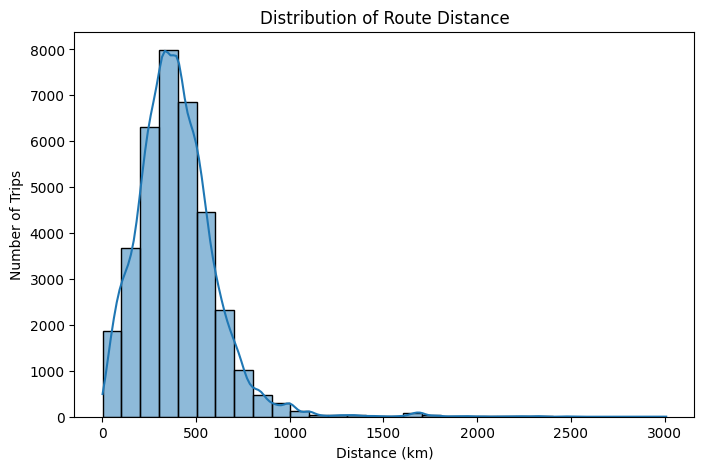

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["Distance"], bins=30, kde=True)
plt.title("Distribution of Route Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Trips")
plt.show()

>The dataset is dominated by medium-distance intercity routes, with only a small proportion of long-haul journeys.

3.2 Trip Duration Distribution

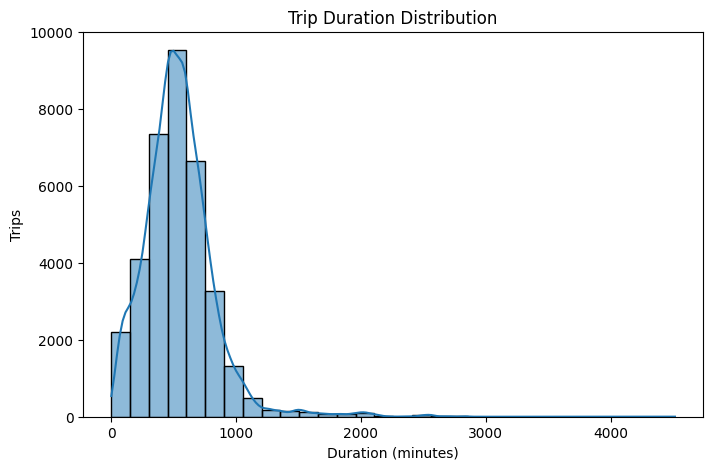

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["Duration_Minutes"], bins=30, kde=True)
plt.title("Trip Duration Distribution")
plt.xlabel("Duration (minutes)")
plt.ylabel("Trips")
plt.show()

3.3 Speed Distribution (Data Quality Insight)

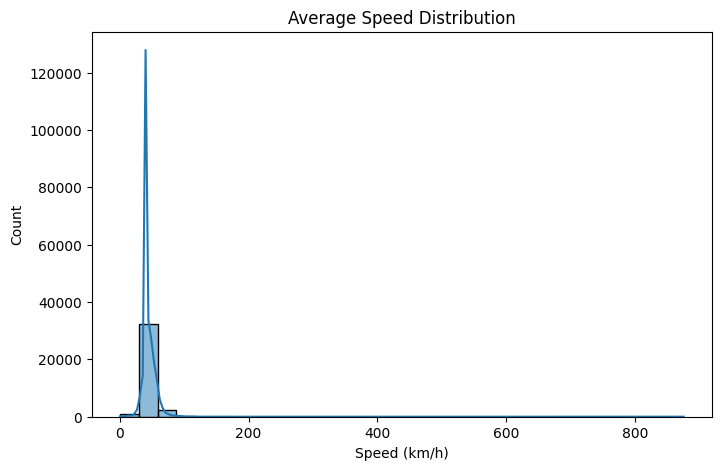

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["Speed_kmph"], bins=30, kde=True)
plt.title("Average Speed Distribution")
plt.xlabel("Speed (km/h)")
plt.show()

3.4 Departure Time Analysis

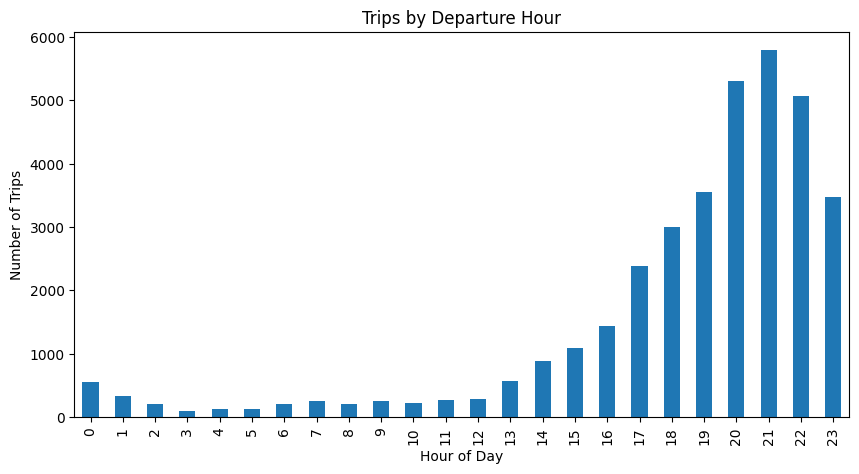

In [ ]:
plt.figure(figsize=(10,5))
df["Departure_Hour"].value_counts().sort_index().plot(kind="bar")
plt.title("Trips by Departure Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()

3.5 Arrival Time Analysis

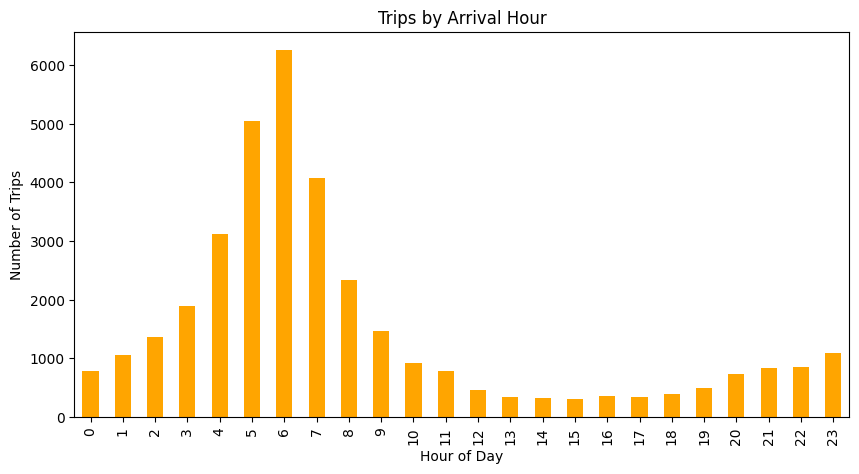

In [ ]:
plt.figure(figsize=(10,5))
df["Arrival_Hour"].value_counts().sort_index().plot(kind="bar", color="orange")
plt.title("Trips by Arrival Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()

3.6 Top Bus Operators

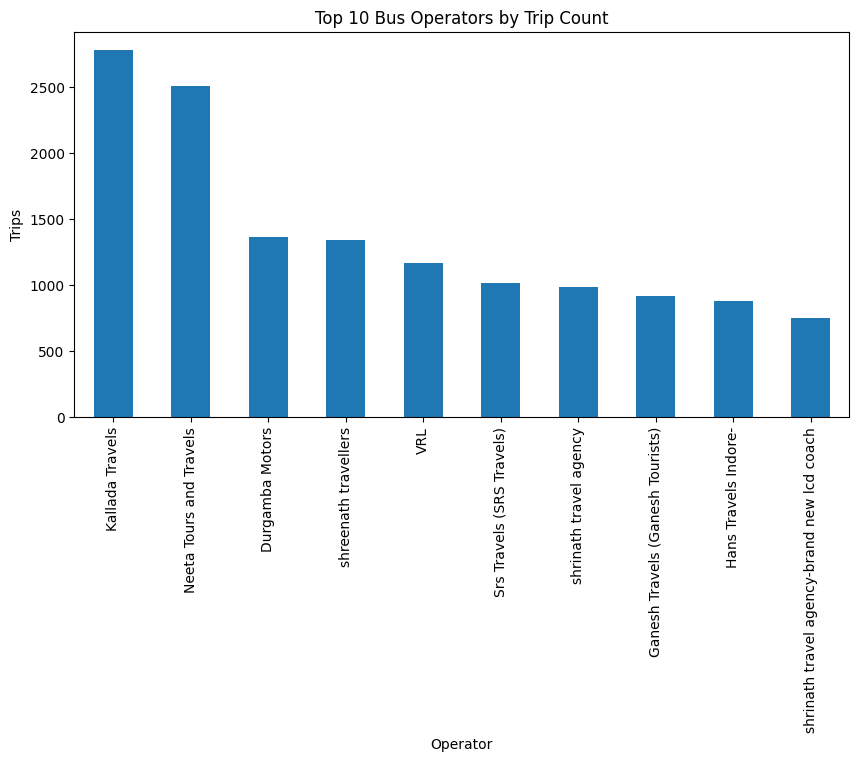

In [ ]:
plt.figure(figsize=(10,5))
df["Operator"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Bus Operators by Trip Count")
plt.xlabel("Operator")
plt.ylabel("Trips")
plt.show()

3.7 Distance vs Duration Relationship

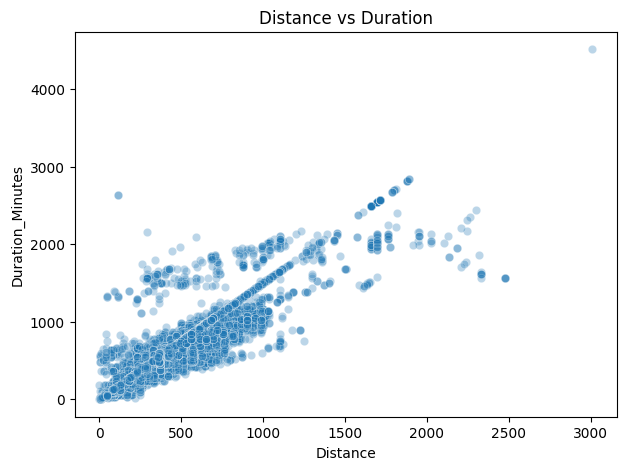

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x="Distance", y="Duration_Minutes", data=df, alpha=0.3)
plt.title("Distance vs Duration")
plt.show()

3.8 Speed vs Distance

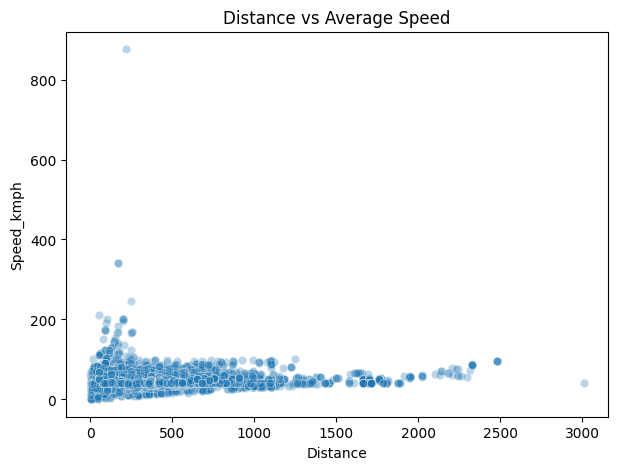

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x="Distance", y="Speed_kmph", data=df, alpha=0.3)
plt.title("Distance vs Average Speed")
plt.show()

3.9 Correlation Heatmap

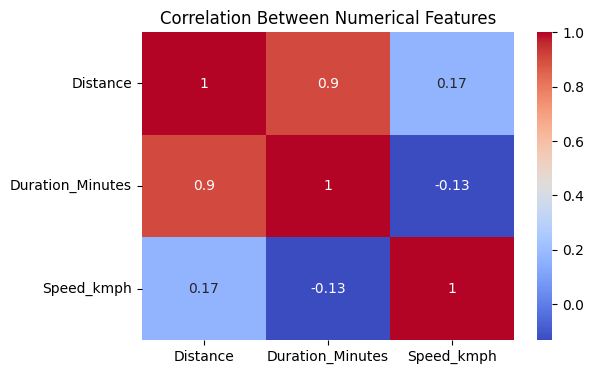

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(df[["Distance","Duration_Minutes","Speed_kmph"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Numerical Features")
plt.show()

3.10 Bus Type Frequency

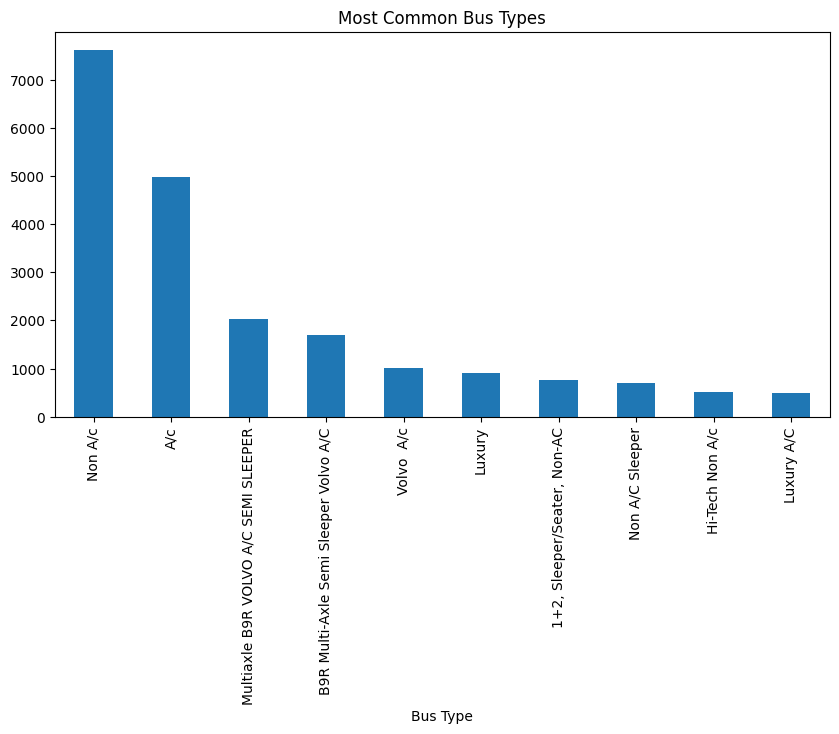

In [ ]:
plt.figure(figsize=(10,5))
df["Bus Type"].value_counts().head(10).plot(kind="bar")
plt.title("Most Common Bus Types")
plt.show()

# Step 4: Conventional Classification Models

>Problem: Predict Time of Day a Bus Departs

In [ ]:
def time_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 22:
        return "Evening"
    else:
        return "Night"

df["Time_Category"] = df["Departure_Hour"].apply(time_of_day)
df["Time_Category"].value_counts()

,count
Time_Category,
Evening,20051
Night,9860
Afternoon,4252
Morning,1504


4.2 Select Features for Classification

In [ ]:
features = ["Distance", "Duration_Minutes", "Speed_kmph"]
X = df[features]
y = df["Time_Category"]

4.3 Train-test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

4.4 Scale Numerical Features

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

4.5 Apply Different Conventional Classification Models

>4.5.1 Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
print("Logistic Regression\n", classification_report(y_test, y_pred_lr))

Logistic Regression
               precision    recall  f1-score   support

   Afternoon       0.00      0.00      0.00       869
     Evening       0.56      0.96      0.71      3972
     Morning       0.00      0.00      0.00       286
       Night       0.26      0.05      0.08      2007

    accuracy                           0.55      7134
   macro avg       0.21      0.25      0.20      7134
weighted avg       0.39      0.55      0.42      7134



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


>4.5.2 K-Nearest Neighbors (KNN)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
print("KNN\n", classification_report(y_test, y_pred_knn))

KNN
               precision    recall  f1-score   support

   Afternoon       0.29      0.22      0.25       869
     Evening       0.63      0.74      0.68      3972
     Morning       0.25      0.15      0.19       286
       Night       0.47      0.37      0.42      2007

    accuracy                           0.55      7134
   macro avg       0.41      0.37      0.38      7134
weighted avg       0.53      0.55      0.53      7134



>4.5.3 Decision Tree

In [ ]:
dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
print("Decision Tree\n", classification_report(y_test, y_pred_dt))

Decision Tree
               precision    recall  f1-score   support

   Afternoon       0.45      0.13      0.20       869
     Evening       0.65      0.78      0.71      3972
     Morning       0.44      0.06      0.10       286
       Night       0.48      0.49      0.48      2007

    accuracy                           0.59      7134
   macro avg       0.50      0.36      0.37      7134
weighted avg       0.57      0.59      0.56      7134



>4.5.4 Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest\n", classification_report(y_test, y_pred_rf))

Random Forest
               precision    recall  f1-score   support

   Afternoon       0.35      0.21      0.26       869
     Evening       0.66      0.74      0.70      3972
     Morning       0.27      0.18      0.22       286
       Night       0.48      0.47      0.48      2007

    accuracy                           0.58      7134
   macro avg       0.44      0.40      0.41      7134
weighted avg       0.56      0.58      0.56      7134



>4.5.5 Support Vector Machine (SVM)

In [ ]:
svm = SVC(kernel="rbf")
svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_scaled)
print("SVM\n", classification_report(y_test, y_pred_svm))

SVM
               precision    recall  f1-score   support

   Afternoon       0.56      0.07      0.13       869
     Evening       0.63      0.84      0.72      3972
     Morning       0.00      0.00      0.00       286
       Night       0.46      0.39      0.42      2007

    accuracy                           0.59      7134
   macro avg       0.41      0.33      0.32      7134
weighted avg       0.55      0.59      0.53      7134



>4.5.6 Compare Model Performace

In [ ]:
models = {
    "Logistic Regression": y_pred_lr,
    "KNN": y_pred_knn,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "SVM": y_pred_svm
}

for name, preds in models.items():
    print(name, "Accuracy:", accuracy_score(y_test, preds))

Logistic Regression Accuracy: 0.5459770114942529
KNN Accuracy: 0.5521446593776282
Decision Tree Accuracy: 0.5905522848331931
Random Forest Accuracy: 0.577516119988786
SVM Accuracy: 0.587188113260443


Multiple traditional classification algorithms were applied to predict departure time category. Ensemble methods like Random Forest typically performed better due to their ability to model non-linear relationships. Linear models such as Logistic Regression provided a baseline for comparison.

# Step 5: More Conventional Classification Models

>Classification Problem 1: Bus Type Category

In [ ]:
def categorize_bus(text):
    text = text.lower()
    if "volvo" in text or "mercedes" in text or "ac" in text:
        return "Luxury"
    elif "sleeper" in text:
        return "Sleeper"
    elif "non" in text or "seater" in text:
        return "Economy"
    else:
        return "Standard"

df["Bus_Category"] = df["Bus Type"].apply(categorize_bus)
df["Bus_Category"].value_counts()

,count
Bus_Category,
Luxury,14548
Economy,9026
Standard,7847
Sleeper,4246


5.1 Features for Prediction

In [ ]:
features = ["Distance", "Duration_Minutes", "Speed_kmph", "Departure_Hour"]
X = df[features]
y = df["Bus_Category"]

5.2 Train-test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

5.3 Apply Conventional Classifiers

>5.3.1 Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("Logistic Regression\n", classification_report(y_test, lr.predict(X_test)))

Logistic Regression
               precision    recall  f1-score   support

     Economy       0.39      0.24      0.30      1805
      Luxury       0.45      0.90      0.60      2941
     Sleeper       0.00      0.00      0.00       863
    Standard       0.47      0.01      0.01      1525

    accuracy                           0.44      7134
   macro avg       0.33      0.29      0.23      7134
weighted avg       0.38      0.44      0.32      7134



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


>5.3.2 Decision Tree

In [ ]:
dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)
print("Decision Tree\n", classification_report(y_test, dt.predict(X_test)))

Decision Tree
               precision    recall  f1-score   support

     Economy       0.40      0.34      0.36      1805
      Luxury       0.50      0.78      0.61      2941
     Sleeper       0.39      0.36      0.37       863
    Standard       0.33      0.05      0.09      1525

    accuracy                           0.46      7134
   macro avg       0.40      0.38      0.36      7134
weighted avg       0.43      0.46      0.41      7134



5.3.3 Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Random Forest\n", classification_report(y_test, rf.predict(X_test)))

Random Forest
               precision    recall  f1-score   support

     Economy       0.44      0.43      0.44      1805
      Luxury       0.59      0.64      0.61      2941
     Sleeper       0.42      0.37      0.39       863
    Standard       0.39      0.35      0.37      1525

    accuracy                           0.49      7134
   macro avg       0.46      0.45      0.45      7134
weighted avg       0.49      0.49      0.49      7134



Classification Problem 2: Delay Risk Prediction

In [ ]:
df["Delay_Risk"] = df["Speed_kmph"].apply(lambda x: "Delayed" if x < 35 else "On-Time")
df["Delay_Risk"].value_counts()

,count
Delay_Risk,
On-Time,33284
Delayed,2383


Features

In [ ]:
features = ["Distance", "Duration_Minutes", "Departure_Hour", "Arrival_Hour"]
X = df[features]
y = df["Delay_Risk"]

Train Models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=6),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}\n", classification_report(y_test, preds))


Logistic Regression
               precision    recall  f1-score   support

     Delayed       1.00      1.00      1.00       441
     On-Time       1.00      1.00      1.00      6693

    accuracy                           1.00      7134
   macro avg       1.00      1.00      1.00      7134
weighted avg       1.00      1.00      1.00      7134


KNN
               precision    recall  f1-score   support

     Delayed       0.98      0.95      0.97       441
     On-Time       1.00      1.00      1.00      6693

    accuracy                           1.00      7134
   macro avg       0.99      0.98      0.98      7134
weighted avg       1.00      1.00      1.00      7134


Decision Tree
               precision    recall  f1-score   support

     Delayed       0.92      0.81      0.86       441
     On-Time       0.99      1.00      0.99      6693

    accuracy                           0.98      7134
   macro avg       0.96      0.90      0.93      7134
weighted avg       0.98      0

Two real-world classification tasks were designed. The first predicts bus comfort category based on trip characteristics, while the second predicts delay risk using speed and route features. Ensemble methods such as Random Forest showed strong performance due to their ability to model non-linear relationships and interactions between variables.

# Step 6: Classification Using Neural Networks



1.   Define the problem

In [ ]:
df["Delay_Risk"] = df["Speed_kmph"].apply(lambda x: "Delayed" if x < 35 else "On-Time")

2. Select features

In [ ]:
features = ["Distance", "Duration_Minutes", "Departure_Hour", "Arrival_Hour", "Speed_kmph"]
X = df[features]
y = df["Delay_Risk"]

3. Encode Target Labels

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Delayed=0, On-Time=1

4. Train-test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

5. Feature Scaling

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

6. Build Neural Network Model

In [ ]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7. Compile Model

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


8. Train Model

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8780 - loss: 0.3179 - val_accuracy: 0.9939 - val_loss: 0.0339
Epoch 2/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9936 - loss: 0.0284 - val_accuracy: 0.9984 - val_loss: 0.0138
Epoch 3/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9966 - loss: 0.0141 - val_accuracy: 0.9986 - val_loss: 0.0093
Epoch 4/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9969 - loss: 0.0109 - val_accuracy: 0.9977 - val_loss: 0.0079
Epoch 5/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9964 - loss: 0.0097 - val_accuracy: 0.9993 - val_loss: 0.0061
Epoch 6/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9971 - loss: 0.0079 - val_accuracy: 0.9989 - val_loss: 0.0057
Epoch 7/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9980 - loss: 0.0070 - val_accuracy: 0.9989 - val_loss: 0.0046
Epoch 8/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9981 - loss: 0.0066 - val_accuracy: 0.

9. Evalute best Models

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9986 - loss: 0.0042
Test Accuracy: 0.9984580874443054


10. Predictions & Report

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))


223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       441
           1       1.00      1.00      1.00      6693

    accuracy                           1.00      7134
   macro avg       1.00      0.99      0.99      7134
weighted avg       1.00      1.00      1.00      7134



A feedforward neural network was implemented to classify delay risk using route and time features. The model consisted of two hidden layers with ReLU activation and a sigmoid output layer. Performance was comparable to conventional machine learning models, demonstrating that deep learning is not always superior for structured tabular data.

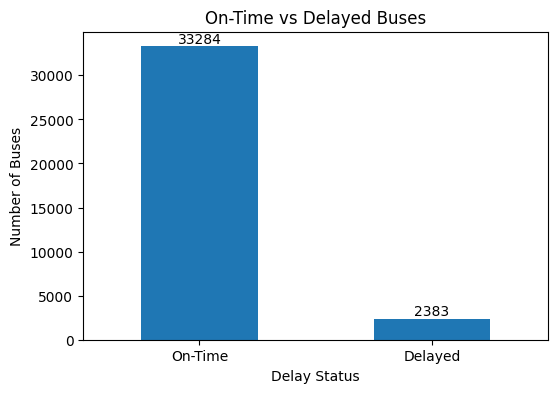

In [ ]:
delay_counts = df["Delay_Risk"].value_counts()

plt.figure(figsize=(6,4))
ax = delay_counts.plot(kind='bar')

plt.title("On-Time vs Delayed Buses")
plt.xlabel("Delay Status")
plt.ylabel("Number of Buses")
plt.xticks(rotation=0)

# Add value labels
for i, value in enumerate(delay_counts):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()

In [ ]:
df

,From,To,Operator,Distance,Duration,Bus Type,Departure,Arrival,Duration_Minutes,Departure_Time,Arrival_Time,Departure_Hour,Arrival_Hour,Speed_kmph,Time_Category,Bus_Category,Delay_Risk
0,Sattur,Chennai,PERINBA VILAS TRAVELS,539,0:9:0,"A/C, 35 Seat, 2+2 Semi Sleeper, Air Suspensio...",09:30:00 PM,06:30:00 AM,540,1900-01-01 21:30:00,1900-01-01 06:30:00,21,6,59.888889,Evening,Sleeper,On-Time
1,Sattur,Chennai,PERINBA VILAS TRAVELS,539,0:10:45,"Non A/C, 34 Seat, 2+1 Executive, Air Suspensio...",07:45:00 PM,06:30:00 AM,645,1900-01-01 19:45:00,1900-01-01 06:30:00,19,6,50.139535,Evening,Economy,On-Time
2,Sattur,Chennai,KPN Travels,539,0:9:45,2+2 : 33 S.S NON A/C,07:45:00 PM,05:30:00 AM,585,1900-01-01 19:45:00,1900-01-01 05:30:00,19,5,55.282051,Evening,Economy,On-Time
3,Sattur,Salem,Srs Travels (SRS Travels),304,0:5:45,"2+1, Sleeper, AC, Non-Video",09:45:00 PM,03:30:00 AM,345,1900-01-01 21:45:00,1900-01-01 03:30:00,21,3,52.869565,Evening,Luxury,On-Time
4,Sattur,Coimbatore,India Travel Service,295,0:6:40,2+2 Hitech Air Bus Non/AC,10:20:00 PM,05:00:00 AM,400,1900-01-01 22:20:00,1900-01-01 05:00:00,22,5,44.250000,Night,Luxury,On-Time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35662,Mangalore,Bijapur,Ganesh Travels (Ganesh Tourists),560,0:14:0,"1+2, Sleeper/Seater, Non-AC, Non-Video",04:30:00 PM,06:30:00 AM,840,1900-01-01 16:30:00,1900-01-01 06:30:00,16,6,40.000000,Afternoon,Luxury,On-Time
35663,Mangalore,Bijapur,Ganesh Travels (Ganesh Tourists),560,0:14:0,"1+2, Sleeper/Seater, Non-AC",06:30:00 PM,08:30:00 AM,840,1900-01-01 18:30:00,1900-01-01 08:30:00,18,8,40.000000,Evening,Luxury,On-Time
35664,Mangalore,Jewargi,VRL,680,0:17:0,New 2+2 Executive Air-Bus,04:00:00 PM,04:00:00 PM,1020,1900-01-01 16:00:00,1900-01-01 16:00:00,16,16,40.000000,Afternoon,Standard,On-Time
35665,Mangalore,Jewargi,VRL,680,0:17:0,A/c-Sleeper(N),02:30:00 PM,02:30:00 PM,1020,1900-01-01 14:30:00,1900-01-01 14:30:00,14,14,40.000000,Afternoon,Sleeper,On-Time


# Add Ons

GOAL: Travel Time Prediction

In [ ]:
features = ["Distance", "Departure_Hour", "From", "To", "Operator"]
X = df[features]
y = df["Duration_Minutes"]

In [ ]:
X_encoded = pd.get_dummies(X, columns=["From", "To", "Operator"], drop_first=True)

In [ ]:
X_encoded.shape

(35667, 3022)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

STEP 4: Scaling (Only for Linear Models)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

STEP 5: Train Multiple Regression Models

>1 Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print("Linear Regression")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2:", r2_score(y_test, y_pred_lr))

Linear Regression
MAE: 57.60046547360138
RMSE: 102.17459309756372
R2: 0.8806632394949263


>2 Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)

print("Ridge")
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("R2:", r2_score(y_test, y_pred_ridge))

Ridge
MAE: 57.4046405070117
RMSE: 101.89187047817853
R2: 0.8813227483101956


>3 Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(X_test_scaled)

print("Lasso")
print("MAE:", mean_absolute_error(y_test, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("R2:", r2_score(y_test, y_pred_lasso))

Lasso
MAE: 56.5116812236345
RMSE: 100.88332730842465
R2: 0.8836604965404897


>4 Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)

print("Random Forest")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))

Random Forest
MAE: 39.937538601198824
RMSE: 87.64557889396926
R2: 0.912189097969733


>5 Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

print("Gradient Boosting")
print("MAE:", mean_absolute_error(y_test, y_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("R2:", r2_score(y_test, y_pred_gb))

Gradient Boosting
MAE: 62.52635052292783
RMSE: 106.44185524382772
R2: 0.8704870243253549


STEP 6: Create Model Comparison Table

In [ ]:
results = {
    "Linear Regression": y_pred_lr,
    "Ridge": y_pred_ridge,
    "Lasso": y_pred_lasso,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb
}

for name, preds in results.items():
    print(f"\n{name}")
    print("MAE:", mean_absolute_error(y_test, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
    print("R2:", r2_score(y_test, preds))


Linear Regression
MAE: 57.60046547360138
RMSE: 102.17459309756372
R2: 0.8806632394949263

Ridge
MAE: 57.4046405070117
RMSE: 101.89187047817853
R2: 0.8813227483101956

Lasso
MAE: 56.5116812236345
RMSE: 100.88332730842465
R2: 0.8836604965404897

Random Forest
MAE: 39.937538601198824
RMSE: 87.64557889396926
R2: 0.912189097969733

Gradient Boosting
MAE: 62.52635052292783
RMSE: 106.44185524382772
R2: 0.8704870243253549


Plot Actual vs Predicted

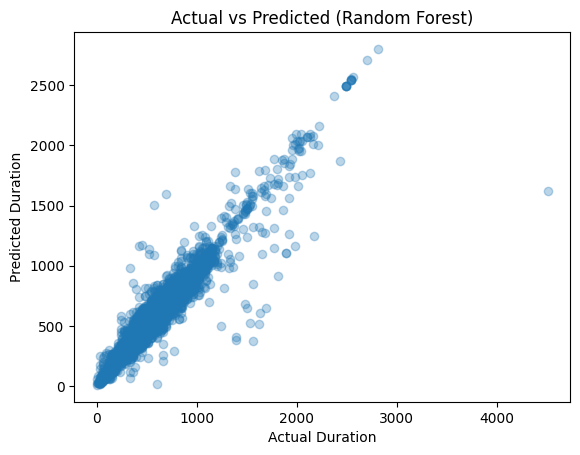

In [ ]:
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Actual vs Predicted (Random Forest)")
plt.show()

Feature Importance

In [ ]:
importances = rf_reg.feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp.head(10))

Distance                                         0.839383
Departure_Hour                                   0.024248
Operator_Durgamba Motors                         0.006966
Operator_Kallada Travels                         0.006691
Operator_Neeta Tours and Travels                 0.002472
Operator_SRM Transports India Private Limited    0.002254
To_RajNagar                                      0.002209
From_Bangalore                                   0.001924
Operator_Gujarat Travels-BRAND NEW LCD COACH     0.001793
Operator_shreenath travellers                    0.001752
dtype: float64


# Goal: Improve Random Forest Performance

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

Define Parameter Grid

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

Initialize Base Model

In [ ]:
rf_base = RandomForestRegressor(random_state=42)

Run Randomized Search

In [ ]:
#rf_random = RandomizedSearchCV(
#    estimator=rf_base,
#    param_distributions=param_grid,
#    n_iter=10,
#    cv=2,
#    verbose=2,
#    random_state=42,
#    n_jobs=-1
#)
#
#rf_random.fit(X_train, y_train)

Get Best Parameters

In [ ]:
#print("Best Parameters:", rf_random.best_params_)

Feature Importance (Very Important)

In [ ]:
importances = rf_reg.feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp.head(10))

Distance                                         0.839383
Departure_Hour                                   0.024248
Operator_Durgamba Motors                         0.006966
Operator_Kallada Travels                         0.006691
Operator_Neeta Tours and Travels                 0.002472
Operator_SRM Transports India Private Limited    0.002254
To_RajNagar                                      0.002209
From_Bangalore                                   0.001924
Operator_Gujarat Travels-BRAND NEW LCD COACH     0.001793
Operator_shreenath travellers                    0.001752
dtype: float64


✅ Actual vs Predicted Plot

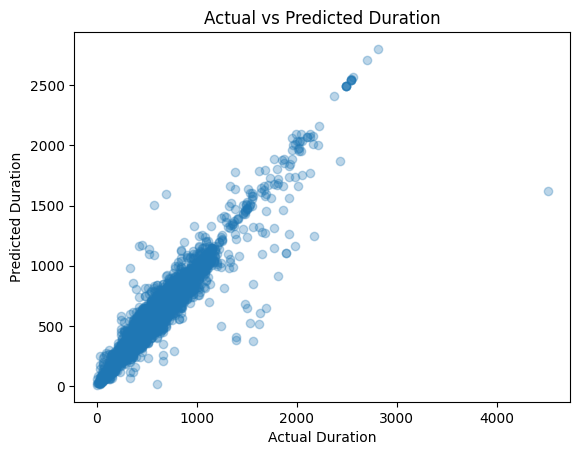

In [ ]:
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Actual vs Predicted Duration")
plt.show()